In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#import opencv
import cv2
import os

import imageio

from google.colab import drive
drive.mount('/content/drive')

shoplifting_folder = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Shop_Lifters/Shop_Lifters'
non_shoplifting_folder = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Shop_Lifters/Non_Shop_Lifters'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [2]:
def Frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=2):
    '''
    Creates frames from each video file present for each category.
    '''
    if not os.path.exists(video_path):
        print(f"Error: The video file at {video_path} does not exist.")
        return None

    result = []
    src = cv2.VideoCapture(video_path)

    if not src.isOpened():
        print(f"Error: Could not open video file {video_path}.")
        return None

    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_length == 0:
        print(f"Error: The video file {video_path} has no frames.")
        return None

    need_length = 1 + (n_frames - 1) * frame_step
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = np.random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)

    # Read the first frame
    ret, frame = src.read()

    if ret and frame is not None:
        print(f"First frame shape: {frame.shape}, dtype: {frame.dtype}")  # Debug print
        result.append(format_frames(frame, output_size))
    else:
        print(f"Warning: Could not read the first frame from {video_path}")
        return None

    # Read the remaining frames
    for i in range(n_frames - 1):
        for j in range(frame_step):
            ret, frame = src.read()
        if ret and frame is not None:
            print(f"Read frame shape: {frame.shape}, dtype: {frame.dtype}")  # Debug print
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            print(f"Warning: Could not read frame at index {i} from {video_path}")
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB



    return result


In [3]:
def format_frames(frame,output_size):
    '''
    pad and resizes the frame

    args:
    frame: frame to be resized
    output_size: size of the output frame

    returns:
    resized and normalized frame
    '''
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [4]:
# Create a function to process all videos in a folder
def process_videos_from_folder(folder_path, label, n_frames, output_size=(224, 224), frame_step=2):
    video_data = []
    video_labels = []

    for video_file in os.listdir(folder_path):
        video_path = os.path.join(folder_path, video_file)

        # Check if the file is a video
        if video_file.endswith(('.mp4', '.avi', '.mov')):
            # Extract frames from the video
            frames = Frames_from_video_file(video_path, n_frames, output_size, frame_step)

            # Append the frames and the label to the lists
            video_data.append(frames)
            video_labels.append(label)

    return np.array(video_data), np.array(video_labels)

In [5]:
# Number of frames to extract from each video
n_frames = 4

# Extract frames from both folders
shoplifting_videos, shoplifting_labels = process_videos_from_folder(shoplifting_folder, label=1, n_frames=n_frames)
non_shoplifting_videos, non_shoplifting_labels = process_videos_from_folder(non_shoplifting_folder, label=0, n_frames=n_frames)

# Combine the data and labels from both categories
all_videos = np.concatenate([shoplifting_videos, non_shoplifting_videos], axis=0)
all_labels = np.concatenate([shoplifting_labels, non_shoplifting_labels], axis=0)

print(f'Total videos: {len(all_videos)}, Labels: {len(all_labels)}')

# Create a TensorFlow dataset from your video data and labels
train_ds = tf.data.Dataset.from_tensor_slices((all_videos, all_labels))

# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size=64)

First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704, 3), dtype: uint8
First frame shape: (576, 704, 3), dtype: uint8
Read frame shape: (576, 704,

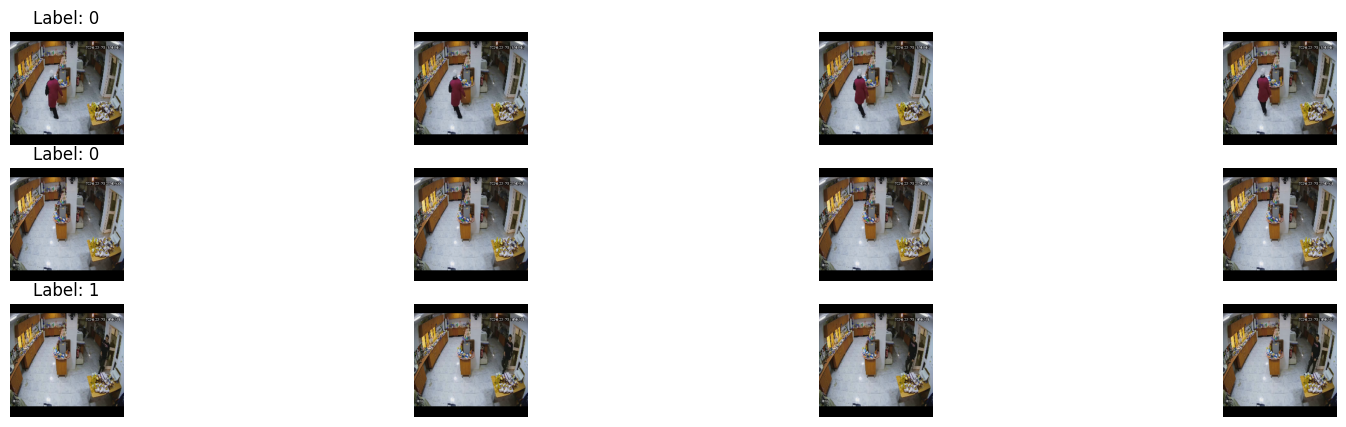

In [6]:
def plot_sample_frames(videos, labels, n_samples=3):
    '''
    Plot a sample of frames from the video dataset.

    Args:
    videos: list of video frames
    labels: corresponding labels
    n_samples: number of samples to plot
    '''
    fig, axs = plt.subplots(n_samples, n_frames, figsize=(20, 5))

    for i in range(n_samples):
        video_idx = np.random.randint(0, len(videos))
        for j in range(n_frames):
            axs[i, j].imshow(videos[video_idx][j])
            axs[i, j].axis('off')

        axs[i, 0].set_title(f'Label: {labels[video_idx]}')

    plt.show()

# Plot a sample of videos with their labels
plot_sample_frames(all_videos, all_labels)

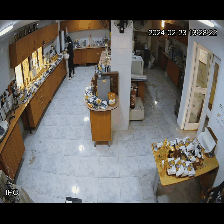

In [7]:
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display

def to_gif(images):
    '''
    Creates GIF from the frames.

    Args:
    images: frames to be converted to gif.

    Returns:
    gif (displayed inline).
    '''

    # Convert images to the range [0, 255] and clip to ensure valid pixel values
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)

    # Calculate duration from fps (e.g., 10 fps -> 100 ms per frame)
    duration = 1000/ 10  # 10 fps

    # Save the GIF using duration instead of fps
    imageio.mimsave('./animation.gif', converted_images, duration=duration)

    # Display the GIF
    display(Image(filename='./animation.gif'))

# Create a GIF from the first video frames
to_gif(all_videos[1])


In [8]:
# Print the shape of the first video in the 'all_videos' array
print(f"Shape of the first video: {all_videos[2].shape}")

Shape of the first video: (4, 224, 224, 3)


In [9]:
# Combine the data and labels from both categories
all_videos = np.concatenate([shoplifting_videos, non_shoplifting_videos], axis=0)
all_labels = np.concatenate([shoplifting_labels, non_shoplifting_labels], axis=0)
print(f'Total videos: {len(all_videos)}, Labels: {len(all_labels)}')

Total videos: 855, Labels: 855


In [10]:
class Conv2Plus1D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then applies the convolution operation over the temporal dimension.
        """
        super().__init__()
        self.seq = keras.Sequential([
            # Spatial decomposition
            layers.Conv3D(filters=filters,
                          # The kernel size was incorrectly passed here. Changed kernel_size to kernel_size[1]
                          kernel_size=(1, kernel_size[1], kernel_size[2]),
                          padding=padding),
            layers.BatchNormalization(),
            # Temporal decomposition
            layers.Conv3D(filters=filters,
                          # The kernel size was incorrectly passed here. Changed kernel_size to kernel_size[0]
                          kernel_size=(kernel_size[0], 1, 1),
                          padding=padding),
            layers.BatchNormalization()
        ])

    def call(self, x):
        return self.seq(x)

In [11]:
class ResidualMain(keras.layers.Layer):
    """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
    """
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.seq = keras.Sequential([
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters,
                        kernel_size=kernel_size,
                        padding='same'),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

In [12]:
class Project(keras.layers.Layer):
    """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
    """
    def __init__(self, units):
        super().__init__()
        self.seq = keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization()
        ])

    def call(self, x):
        return self.seq(x)

In [13]:
def add_residual_block(input, filters, kernel_size):
    """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
    """
    out = ResidualMain(filters,
                       kernel_size)(input)

    res = input
    # Using the Keras functional APIs, project the last dimension of the tensor to
    # match the new filter size
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)

    return layers.add([res, out])

In [14]:
!pip install einops
import einops

class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        """
        Use the einops library to resize the tensor.

        Args:
            video: Tensor representation of the video, in the form of a set of frames.

        Return:
            A downsampled size of the video according to the new height and width it should be resized to.
        """
        # b stands for batch size, t stands for time, h stands for height,
        # w stands for width, and c stands for the number of channels.
        old_shape = einops.parse_shape(video, 'b t h w c')
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        images = self.resizing_layer(images)
        videos = einops.rearrange(
            images, '(b t) h w c -> b t h w c',
            t = old_shape['t'])
        return videos

In [15]:
HEIGHT = 224
WIDTH = 224

In [16]:
input_shape = (None, 4, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [17]:
frames, label = next(iter(train_ds))
model.build(frames)

In [18]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [19]:
model.fit(all_videos, all_labels, epochs=10, batch_size=4, validation_split=0.2)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 882s 5s/step - accuracy: 0.4703 - loss: 1.2274 - val_accuracy: 0.0000e+00 - val_loss: 10.8392
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 844s 5s/step - accuracy: 0.8515 - loss: 0.3440 - val_accuracy: 0.0000e+00 - val_loss: 7.2407
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 843s 5s/step - accuracy: 0.9213 - loss: 0.2313 - val_accuracy: 0.0000e+00 - val_loss: 7.1709
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 840s 5s/step - accuracy: 0.9325 - loss: 0.1825 - val_accuracy: 0.0000e+00 - val_loss: 3.6031
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 888s 5s/step - accuracy: 0.9778 - loss: 0.0962 - val_accuracy: 1.0000 - val_loss: 4.8061e-05
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 838s 5s/step - accuracy: 0.9656 - loss: 0.1087 - val_accuracy: 0.4971 - val_loss: 1.5864
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 867s 5s/step - accuracy: 0.9853 - loss: 0.0511 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 839s 5s/step - accuracy: 0.9801 - lo

In [ ]:
results=model.evaluate(all_videos, all_labels, batch_size=4)

In [ ]:
#plot loss
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:

#plot accuracy
plt.plot(model.history['accuracy'], label='train acc')
plt.plot(model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()